# Toxic Text Classification using BERT

This notebook implements toxic text classification using the following steps:
1. Data loading and preprocessing
2. Feature extraction
3. Model training
4. Evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc

import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

2025-04-13 02:13:30.973741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744510411.154985      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744510411.205886      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Load data
train_df = pd.read_csv('/kaggle/input/nlp-big/train.csv')
train_df = train_df.head(1000)
test_df = pd.read_csv('/kaggle/input/nlp-big/test.csv')
validation_df = pd.read_csv('/kaggle/input/nlp-big/validation.csv')

# Print sample data
print("Training data shape:", train_df.shape)
print("\nSample training data:")
print(train_df.head())

Training data shape: (1000, 8)

Sample training data:
                 id                                      feedback_text  toxic  \
0  281d77b7bebc2201  :::Sounds good.  Let me know when you're done ...      0   
1  716aac7bf3c63db1  "\nI say something, but it didn't actually con...      0   
2  57cb318c6edcf10c  "Agustina Barrientos]] \n | Modelo de Piñeiro ...      0   
3  dc3bd70118d91b3a  FYI I enjoy licking strangers scrotal sacks......      1   
4  cf10d41f2997d233  How do you get a site?\nMany penguins have ask...      0   

   abusive  vulgar  menace  offense  bigotry  
0        0       0       0        0        0  
1        0       0       0        0        0  
2        0       0       0        0        0  
3        0       1       0        0        0  
4        0       0       0        0        0  


In [4]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

# Apply preprocessing
train_df['processed_text'] = train_df['feedback_text'].apply(preprocess_text)
test_df['processed_text'] = test_df['content'].apply(preprocess_text)

In [5]:
# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

def prepare_data(texts, labels):
    # Tokenize texts
    encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=128)
    
    # Convert to tensors
    input_ids = torch.tensor(encodings['input_ids'])
    attention_mask = torch.tensor(encodings['attention_mask'])
    labels = torch.tensor(labels.values)
    
    return TensorDataset(input_ids, attention_mask, labels)

# Prepare training data
train_dataset = prepare_data(train_df['processed_text'], train_df['toxic'])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}')

Epoch 1/3, Average Loss: 0.2959
Epoch 2/3, Average Loss: 0.1852
Epoch 3/3, Average Loss: 0.1121


In [9]:
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2]
            
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.numpy())
            
    return predictions, true_labels

# Prepare test data
test_dataset = prepare_data(validation_df['feedback_text'], validation_df['toxic'])
test_loader = DataLoader(test_dataset, batch_size=32)

# Get predictions
predictions, true_labels = evaluate_model(model, test_loader)

Accuracy: 0.8405
Precision: 0.7064
Recall: 0.8405
F1 Score: 0.7676


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


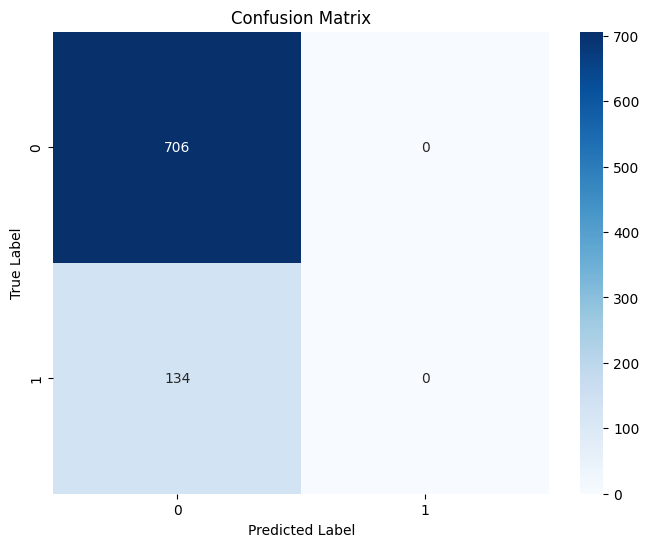

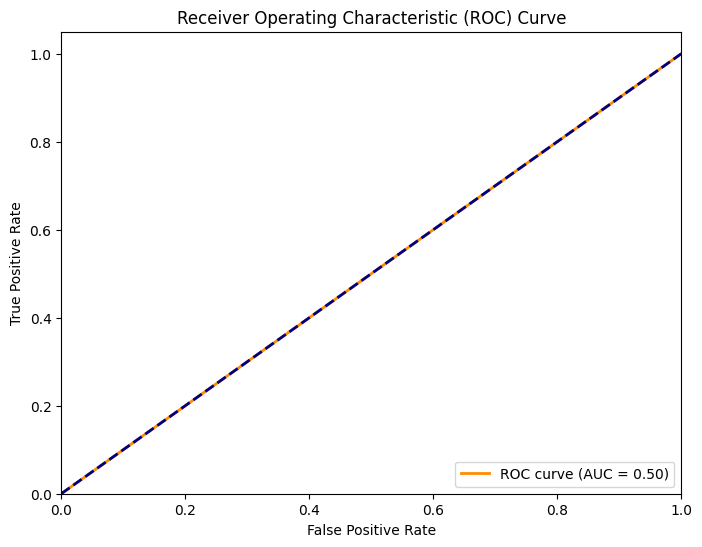

In [11]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average="weighted")
recall = recall_score(true_labels, predictions, average="weighted")
f1 = f1_score(true_labels, predictions, average="weighted")

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Plot confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()